
# HalfCheetah: Learn a Dynamics Model from Random Rollouts (Then Validate It)

**Goal:** In this notebook you'll (1) collect random experience tuples \((s_t, a_t, r_t, s_{t+1})\) from `HalfCheetah-v4`, (2) train a neural network to predict **state deltas** \(\Delta s = s_{t+1}-s_t\), and (3) **validate** the model with one-step and multi-step (open-loop) rollouts.

This mirrors the first phase of model-based control (e.g., MPPI): learn a model offline, then use it for planning.



## 0. Requirements

- Python 3.9+
- PyTorch `>= 1.10`
- Gymnasium `>= 0.29`
- MuJoCo with `HalfCheetah-v4` (install `mujoco` and `gymnasium[mujoco]`)

```bash
pip install "gymnasium[mujoco]" mujoco torch matplotlib
```

**Try and understand what RunningNormalizer does.**


In [4]:
%pip install "gymnasium[mujoco]" mujoco torch matplotlib

Note: you may need to restart the kernel to use updated packages.


In [39]:

import os, math, random, time
from dataclasses import dataclass
from typing import Tuple
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym

def to_t(x): 
    return th.as_tensor(x, dtype=th.float32)

def fanin_init(m):
    if isinstance(m, nn.Linear):
        bound = 1.0 / math.sqrt(m.weight.size(1))
        nn.init.uniform_(m.weight, -bound, +bound)
        nn.init.zeros_(m.bias)

class RunningNormalizer:
    """Feature-wise running mean/std (Welford)."""
    def __init__(self, dim, eps=1e-8):
        self.dim = dim
        self.count = 0
        self.mean = np.zeros(dim, dtype=np.float64)
        self.M2   = np.zeros(dim, dtype=np.float64)
        self.eps  = eps

    def update(self, x: np.ndarray):
        x = np.asarray(x)
        if x.ndim == 1: x = x[None, :]
        for v in x:
            self.count += 1
            d = v - self.mean
            self.mean += d / self.count
            d2 = v - self.mean
            self.M2 += d * d2

    @property
    def var(self):
        if self.count < 2: return np.ones(self.dim, dtype=np.float64)
        return self.M2 / (self.count - 1 + 1e-12)

    @property
    def std(self): 
        return np.sqrt(self.var + self.eps)

    def normalize(self, x): return (x - self.mean) / self.std
    def denormalize(self, x): return x * self.std + self.mean

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); th.manual_seed(seed)



## Initializing Environment and Figure Out Observation Structure

`HalfCheetah-v4` exposes observations as `[qpos[1:], qvel[:]]`. The forward velocity is `qvel[0]`, which sits at index `len(qpos[1:])` inside the observation vector. We'll extract that index for later validation/plots. :::: This is important for planning, if we want to know what each state represents


In [40]:

set_seed(42)
env = gym.make("HalfCheetah-v4")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_low = env.action_space.low
act_high = env.action_space.high

# Find start index of qvel inside obs = [qpos[1:], qvel[:]]
nq = env.unwrapped.model.nq
qvel_start = int(nq - 1)
print("obs_dim:", obs_dim, "act_dim:", act_dim, "qvel_start:", qvel_start)


obs_dim: 17 act_dim: 6 qvel_start: 8


## 🧩 Task 1: Prepare the Replay Buffer
**Goal:** Store transitions \((s_t, a_t, s_{t+1})\) and return training pairs \((x, y) = (s_t, a_t, s_{t+1} - s_t)\).

**Instructions:**
- Implement `add()` to record transitions.
- Add a `sample()` method to randomly sample batch of certain size.



In [41]:
# Create the class and create a class object
class Replay:
    def __init__(self, obs_dim, act_dim, capacity=300000):
        self.obs = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.act = np.zeros((capacity, act_dim), dtype=np.float32)
        self.nxt = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.rew = np.zeros((capacity, 1), dtype=np.float32)
        self.term = np.zeros((capacity, 1), dtype=np.float32)
        self.ptr = 0; self.size = 0; self.cap = capacity

    def add(self, s, a, r, sp, term):
        """Store one transition (ring buffer)."""
        i = self.ptr % self.cap
        self.obs[i]  = s
        self.act[i]  = a
        self.nxt[i]  = sp
        self.rew[i]  = r
        self.term[i] = float(term)
        self.ptr += 1
        if self.size < self.cap:
            self.size += 1

    def sample(self, batch, as_pairs=True, rng=None):
        """
        Random sample.
        If as_pairs=True, returns (X, Y) where:
          X = concat([s, a])
          Y = (s_next - s)   # state delta
        Otherwise returns raw (s, a, r, sp, term).
        """
        if self.size == 0:
            raise ValueError("Replay is empty.")
        rng = np.random.default_rng() if rng is None else rng
        idx = rng.integers(0, self.size, size=batch)

        s  = self.obs[idx]
        a  = self.act[idx]
        sp = self.nxt[idx]
        r  = self.rew[idx]
        d  = self.term[idx]

        if as_pairs:
            X = np.concatenate([s, a], axis=1).astype(np.float32, copy=False)
            Y = (sp - s).astype(np.float32, copy=False)
            return X, Y
        else:
            return s, a, r, sp, d

replay = Replay(obs_dim, act_dim)



## Task 2. Collect Random Rollouts

- Gather random actions for a number of steps to create our training dataset. Collect data for 100000 steps. 
- Call the function and fill the replay buffer


In [42]:

def collect_random(env, replay, steps=100_000, seed=42):
    """
    Roll out random actions for `steps` env steps and push transitions into `replay`.

    Stores (s, a, r, s', done) where done = terminated OR truncated.
    """
    rng = np.random.default_rng(seed)
    obs, _ = env.reset(seed=seed)

    low, high = env.action_space.low, env.action_space.high
    n = 0
    ep_returns, ep_len, ret = [], 0, 0.0

    while n < steps:
        # random continuous action in valid bounds
        a = rng.uniform(low, high).astype(np.float32)

        nxt, r, terminated, truncated, _ = env.step(a)
        done = bool(terminated or truncated)

        replay.add(obs, a, r, nxt, done)

        # bookkeeping
        ret += float(r); ep_len += 1; n += 1

        if done:
            ep_returns.append(ret)
            ret, ep_len = 0.0, 0
            obs, _ = env.reset()
        else:
            obs = nxt

    return {
        "steps": n,
        "episodes": len(ep_returns),
        "avg_return": float(np.mean(ep_returns)) if ep_returns else 0.0
    }



## Task 3. Update normalizers from the collected random data in the replay buffer

We normalize inputs (`[s,a]`) and targets (`Δs = s' - s`) for stable training.


In [43]:

obs_norm = RunningNormalizer(obs_dim)
inp_norm = RunningNormalizer(obs_dim + act_dim)
targ_norm = RunningNormalizer(obs_dim)

# write the function to update the normalizers from the data collected in the buffer
def update_normalizers_from_buffer(replay, chunk=65_536):
    """
    Fit the running normalizers from transitions stored in `replay`.
    Uses chunking to avoid large temporary allocations.
    """
    n = replay.size
    if n == 0:
        print("Replay is empty — collect data first.")
        return

    for start in range(0, n, chunk):
        sl = slice(start, min(start + chunk, n))
        s  = replay.obs[sl]           # (B, obs_dim)
        a  = replay.act[sl]           # (B, act_dim)
        sp = replay.nxt[sl]           # (B, obs_dim)

        X = np.concatenate([s, a], axis=1)   # inputs [s, a]
        Y = sp - s                            # targets Δs

        obs_norm.update(s)
        obs_norm.update(sp)
        inp_norm.update(X)
        targ_norm.update(Y)

update_normalizers_from_buffer(replay)
print("Normalizers ready.")


Replay is empty — collect data first.
Normalizers ready.



## Defining the Neural Dynamics Model

We predict **normalized** `Δs` from **normalized** `[s, a]`.
NN parameters: 

- initialize a deterministic NN with a ExponentialLR sceduler( that decays the learning rate with epoch)
- width = 200, depth = 3, lr = 1e-3, weight_decay - 1e-5, gamma for scheduler = 0.8
- These are a starting point but not the best parameters. 


In [44]:
# ----- Model -----
import math, numpy as np, torch
import torch.nn as nn
import torch.optim as optim

DEVICE = torch.device("cuda")
EPS = 1e-8

def fanin_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class DetMLP(nn.Module):
    """Predicts Δstate deterministically from normalized [s,a]."""
    def __init__(self, in_dim, out_dim, width=200, depth=3):
        super().__init__()
        layers, last = [], in_dim
        for _ in range(depth):
            layers += [nn.Linear(last, width), nn.ReLU()]
            last = width
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
        self.apply(fanin_init)

    def forward(self, x):
        return self.net(x)

# dims from your env
in_dim  = obs_dim + act_dim
out_dim = obs_dim

model = DetMLP(in_dim, out_dim, width=200, depth=3).to(DEVICE)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)

# ----- Normalization helpers (use your RunningNormalizer stats) -----
def _mean_std(n):
    # Works with either torch/np attributes on your RunningNormalizer
    m = getattr(n, "mean", None); s = getattr(n, "std", None)
    if m is None or s is None:      # if class exposes .mu/.sigma
        m = getattr(n, "mu"); s = getattr(n, "sigma")
    return np.asarray(m), np.asarray(s)

_inp_mu, _inp_std   = _mean_std(inp_norm)
_targ_mu, _targ_std = _mean_std(targ_norm)

def norm_inputs(X):
    return (X - _inp_mu) / (np.maximum(_inp_std, EPS))

def norm_targets(Y):
    return (Y - _targ_mu) / (np.maximum(_targ_std, EPS))

def denorm_targets(Yn):
    return Yn * _targ_std + _targ_mu

# ----- One-shot trainer -----
def train_dynamics(model, replay, epochs=25, batch=1024, iters_per_epoch=200):
    model.train()
    mse = nn.MSELoss()
    for ep in range(epochs):
        running = 0.0
        for _ in range(iters_per_epoch):
            X, Y = replay.sample(batch)          # X=[s,a], Y=Δs (both np.float32)
            Xn = norm_inputs(X).astype(np.float32, copy=False)
            Yn = norm_targets(Y).astype(np.float32, copy=False)

            Xt = torch.from_numpy(Xn).to(DEVICE)
            Yt = torch.from_numpy(Yn).to(DEVICE)

            pred = model(Xt)
            loss = mse(pred, Yt)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            running += loss.item()
        scheduler.step()
        print(f"epoch {ep+1:02d}  lr={scheduler.get_last_lr()[0]:.3e}  "
              f"train_mse={running/iters_per_epoch:.6f}")

# ----- Convenience: predict next state with the trained model -----
@torch.no_grad()
def one_step_predict(s, a):
    """
    s: (obs_dim,) np
    a: (act_dim,) np
    returns s_next_pred (obs_dim,) in original (unnormalized) space
    """
    X = np.concatenate([s[None, :], a[None, :]], axis=1).astype(np.float32)
    Xn = norm_inputs(X).astype(np.float32)
    yhat_n = model(torch.from_numpy(Xn).to(DEVICE)).cpu().numpy()[0]
    dS = denorm_targets(yhat_n)
    return (s + dS).astype(np.float32)



## Task 4. Train the Model

We minimize MSE between predicted normalized `Δs` and target normalized `Δs`.

- Train in batches, keep the batch size 256
- Use a learning rate scheduler that decays the learning rate as training progresses. You may use the pytorch utility. See how the learning rate decays with each epoch. 
- Train for 30 epochs and plot the training curve. Loss vs epoch. 
- Find the best parameters(defined in the previous block)



In [ ]:
import numpy as np
import torch
import torch.nn as nn

# assumes you already created:
#   model, opt, scheduler, DEVICE
#   inp_norm, targ_norm
EPS = 1e-8
mse = nn.MSELoss()

# ---------- robust normalizer helpers ----------
def _extract_mean_std(n):
    """Fetch (mean, std) from many RunningNormalizer variants."""
    m = getattr(n, "mean", None)
    if m is None: m = getattr(n, "mu", None)
    if m is None: m = getattr(n, "running_mean", None)

    s = getattr(n, "std", None)
    if s is None: s = getattr(n, "sigma", None)
    if s is None: s = getattr(n, "running_std", None)
    if s is None and hasattr(n, "var"):
        s = np.sqrt(np.maximum(getattr(n, "var"), EPS))

    if (m is None or s is None) and hasattr(n, "state_dict"):
        sd = n.state_dict()
        if m is None:
            for k in ("mean","mu","running_mean","m"):
                if k in sd: m = sd[k]; break
        if s is None:
            for k in ("std","sigma","running_std","s","var"):
                if k in sd:
                    s = sd[k] if k != "var" else np.sqrt(np.maximum(sd[k], EPS))
                    break

    if m is None or s is None:
        raise AttributeError("Could not find mean/std on RunningNormalizer")

    return np.asarray(m), np.asarray(s)

def _norm_inputs(X):
    if hasattr(inp_norm, "normalize"):
        return inp_norm.normalize(X)
    mu, st = _extract_mean_std(inp_norm)
    return (X - mu) / np.maximum(st, EPS)

def _norm_targets(Y):
    if hasattr(targ_norm, "normalize"):
        return targ_norm.normalize(Y)
    mu, st = _extract_mean_std(targ_norm)
    return (Y - mu) / np.maximum(st, EPS)

# ---------- trainer ----------
def train_model(model, replay, epochs=30, batch_size=256, iters_per_epoch=500, clip_grad=1.0):
    """
    Trains `model` to predict normalized Δs from normalized [s,a].
    Uses global `opt`, `scheduler`, `DEVICE`, and the normalizers above.
    """
    model.train()
    losses = []

    for ep in range(epochs):
        running = 0.0
        for _ in range(iters_per_epoch):
            # sample raw pairs: X=[s,a], Y=Δs
            X, Y = replay.sample(batch_size)
            Xn = _norm_inputs(X).astype(np.float32, copy=False)
            Yn = _norm_targets(Y).astype(np.float32, copy=False)

            Xt = torch.from_numpy(Xn).to(DEVICE, non_blocking=True)
            Yt = torch.from_numpy(Yn).to(DEVICE, non_blocking=True)

            pred = model(Xt)
            loss = mse(pred, Yt)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            if clip_grad is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            opt.step()

            running += float(loss.item())

        scheduler.step()
        epoch_loss = running / iters_per_epoch
        losses.append(epoch_loss)
        lr_now = scheduler.get_last_lr()[0]
        print(f"epoch {ep+1:02d} | lr {lr_now:.3e} | train MSE (norm Δs): {epoch_loss:.6f}")

    return losses


In [46]:
# A) Make env + replay (or reuse if already exists)
import gymnasium as gym
env = gym.make("HalfCheetah-v4")

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

# IMPORTANT: don't overwrite a filled buffer. Recreate only if missing or empty.
try:
    _ = replay.size
except NameError:
    replay = Replay(obs_dim, act_dim, capacity=300_000)

if replay.size == 0:
    stats = collect_random(env, replay, steps=100_000, seed=42)
    print("Collected:", stats)
else:
    print(f"Replay already has {replay.size} steps.")

print("replay.size =", replay.size)
assert replay.size > 0

Collected: {'steps': 100000, 'episodes': 100, 'avg_return': -274.1638278195165}
replay.size = 100000


epoch 01 | lr 8.000e-04 | train MSE (norm Δs): 4.833178
epoch 02 | lr 6.400e-04 | train MSE (norm Δs): 1.193823
epoch 03 | lr 5.120e-04 | train MSE (norm Δs): 1.046637
epoch 04 | lr 4.096e-04 | train MSE (norm Δs): 0.960764
epoch 05 | lr 3.277e-04 | train MSE (norm Δs): 0.921367
epoch 06 | lr 2.621e-04 | train MSE (norm Δs): 0.878688
epoch 07 | lr 2.097e-04 | train MSE (norm Δs): 0.853021
epoch 08 | lr 1.678e-04 | train MSE (norm Δs): 0.830346
epoch 09 | lr 1.342e-04 | train MSE (norm Δs): 0.817093
epoch 10 | lr 1.074e-04 | train MSE (norm Δs): 0.796297
epoch 11 | lr 8.590e-05 | train MSE (norm Δs): 0.789961
epoch 12 | lr 6.872e-05 | train MSE (norm Δs): 0.771077
epoch 13 | lr 5.498e-05 | train MSE (norm Δs): 0.775896
epoch 14 | lr 4.398e-05 | train MSE (norm Δs): 0.765643
epoch 15 | lr 3.518e-05 | train MSE (norm Δs): 0.759739
epoch 16 | lr 2.815e-05 | train MSE (norm Δs): 0.758736
epoch 17 | lr 2.252e-05 | train MSE (norm Δs): 0.749741
epoch 18 | lr 1.801e-05 | train MSE (norm Δs): 0

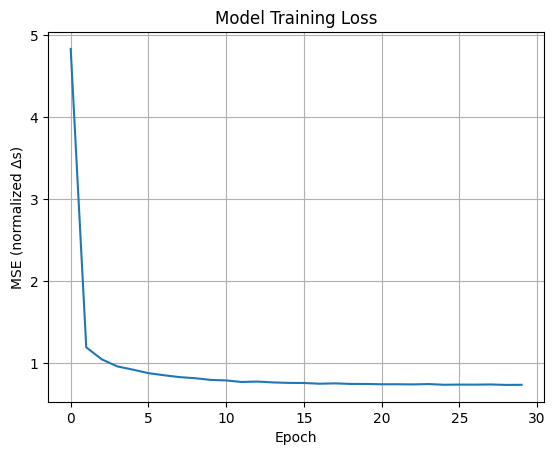

In [47]:
losses = train_model(model, replay, epochs=30, batch_size=256, iters_per_epoch=500)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE (normalized Δs)")
plt.title("Model Training Loss")
plt.grid()
plt.show()


## Task 5. Validate your model: One-Step and Multi-Step Prediction Error

- Evaluate your trained model on a held-out set of random transitions.
Generate a batch of unseen samples, predict the next-state delta, and compute the one-step MSE.

- Repeat with open-loop rollouts of length k.
Drive both the real environment and the model with the same action sequence, then report how prediction error grows across steps.

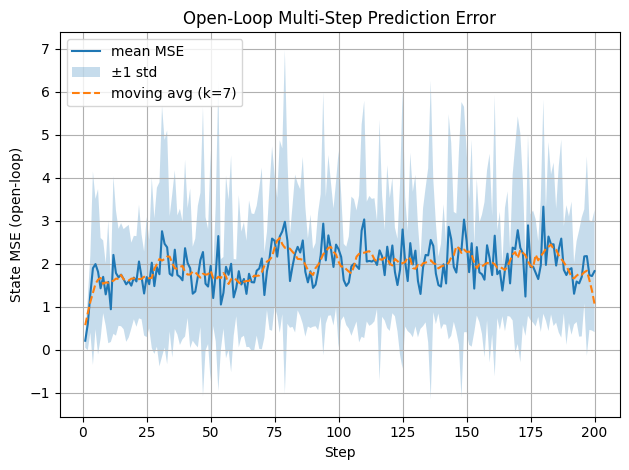

In [58]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Uses helpers from earlier cell: _norm_inputs, _norm_targets
# and the global normalizers inp_norm/targ_norm, model, DEVICE, env

@torch.no_grad()
def _predict_delta_norm(Xn):
    """Xn: normalized [s,a] -> normalized Δs (numpy in, numpy out)."""
    Xt = torch.as_tensor(Xn, dtype=torch.float32, device=DEVICE)
    Yn = model(Xt).cpu().numpy()
    return Yn

def _extract_mean_std_safe(n):
    """Return (mean, std) without using `or` on arrays."""
    m = getattr(n, "mean", None)
    if m is None: m = getattr(n, "mu", None)
    if m is None: m = getattr(n, "running_mean", None)

    s = getattr(n, "std", None)
    if s is None: s = getattr(n, "sigma", None)
    if s is None: s = getattr(n, "running_std", None)
    if s is None and hasattr(n, "var"):
        s = np.sqrt(np.maximum(getattr(n, "var"), 1e-8))

    if (m is None or s is None) and hasattr(n, "state_dict"):
        sd = n.state_dict()
        if m is None:
            for k in ("mean","mu","running_mean","m"):
                if k in sd: m = sd[k]; break
        if s is None:
            for k in ("std","sigma","running_std","s","var"):
                if k in sd:
                    s = sd[k] if k != "var" else np.sqrt(np.maximum(sd[k], 1e-8))
                    break

    if m is None or s is None:
        raise AttributeError("Could not find mean/std on targ_norm.")

    return np.asarray(m), np.asarray(s)

def _denorm_targets(Yn):
    mu, st = _extract_mean_std_safe(targ_norm)
    return Yn * st + mu


# ---- A) One-step validation on held-out samples ----
def validate_one_step(replay, batch=8192, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    # sample *without* replacement if possible
    n = min(batch, replay.size)
    idx = rng.choice(replay.size, size=n, replace=False)
    s  = replay.obs[idx]
    a  = replay.act[idx]
    sp = replay.nxt[idx]

    X  = np.concatenate([s, a], axis=1)
    Y  = sp - s                    # true Δs (unnormalized)

    Xn = _norm_inputs(X)
    Yn_true = _norm_targets(Y)

    Yn_pred = _predict_delta_norm(Xn)
    # MSE in normalized space (this is what the model trains on)
    mse_norm = float(np.mean((Yn_pred - Yn_true)**2))

    # also report unnormalized Δs error
    Y_pred = _denorm_targets(Yn_pred)
    mse_unnorm = float(np.mean((Y_pred - Y)**2))

    return {"mse_norm": mse_norm, "mse_delta": mse_unnorm, "batch_used": n}

# ---- B) Multi-step open-loop rollout error ----
@torch.no_grad()
def rollout_model_step(s, a):
    """One step of learned model in *original* state units."""
    X = np.concatenate([s[None, :], a[None, :]], axis=1).astype(np.float32)
    Xn = _norm_inputs(X)
    Yn_pred = _predict_delta_norm(Xn)
    dS = _denorm_targets(Yn_pred)[0]
    return (s + dS).astype(np.float32)

def validate_open_loop(env, horizon=200, trials=20, seed=0):
    rng = np.random.default_rng(seed)
    low, high = env.action_space.low, env.action_space.high

    all_err = np.full((trials, horizon), np.nan, dtype=np.float64)

    for t in range(trials):
        obs, _ = env.reset(seed=seed + t)
        s_env = obs.astype(np.float32)
        s_mod = s_env.copy()

        for k in range(horizon):
            a = rng.uniform(low, high).astype(np.float32)

            sp_env, _, term, trunc, _ = env.step(a)
            sp_mod = rollout_model_step(s_mod, a)

            all_err[t, k] = np.mean((sp_mod - sp_env)**2)

            if term or trunc:
                break  # stop this trial; keep NaNs for remaining steps

            s_env = sp_env.astype(np.float32)
            s_mod = sp_mod

    mean_err = np.nanmean(all_err, axis=0)
    std_err  = np.nanstd(all_err, axis=0)
    return mean_err, std_err


mean_err, std_err = validate_open_loop(env, horizon=200, trials=20, seed=123)

import matplotlib.pyplot as plt
x = np.arange(1, len(mean_err)+1)
plt.figure()
plt.plot(x, mean_err, label="mean MSE")
plt.fill_between(x, mean_err-std_err, mean_err+std_err, alpha=0.25, label="±1 std")

# smoothing (optional)
k = 7
ma = np.convolve(mean_err, np.ones(k)/k, mode='same')
plt.plot(x, ma, linestyle="--", label=f"moving avg (k={k})")

plt.xlabel("Step")
plt.ylabel("State MSE (open-loop)")
plt.title("Open-Loop Multi-Step Prediction Error")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()




## Task 6. Visualize Rollout Trajectories

**Setup**
Call model.eval() so gradients stay off.
Reset the env with the provided seed; keep a copy of the initial observation.


**Choose actions**
Pre-sample k actions from env.action_space.sample() so the real system and the model rollout see the same sequence.

**Roll forward**
For each action:
Step the real env (env.step(a)), append the new observation.
For the model path:
Build [s_model, a], normalize via inp_norm.normalize, turn into a tensor with to_t.
Run the network, de-normalize with targ_norm.denormalize, add to the last model state, append.
Stop early if the env terminates or truncates.

**Plot**
Plot the real trajectory as one line, model trajectory as another.



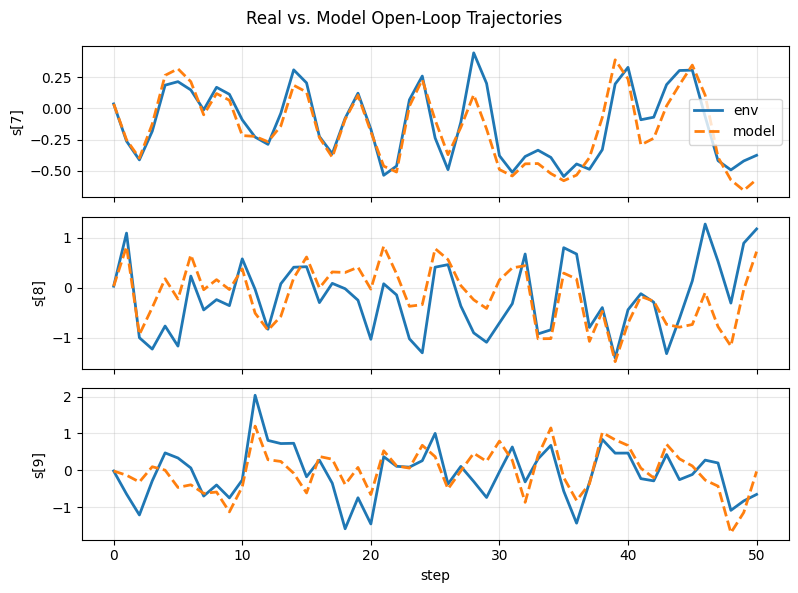

In [62]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Assumes you already have:
#  - env, model, DEVICE
#  - helpers: _norm_inputs(X) and _denorm_targets(Yn) from prior cells

@torch.no_grad()
def visualize_rollout(env, model, k=50, dims=(0, 5, 10), seed=2025):
    """
    Compare k-step open-loop trajectories of the real env vs. learned model.
    dims: iterable of state indices to plot.
    """
    model.eval()
    rng = np.random.default_rng(seed)

    # --- reset & initial state
    s0, _ = env.reset(seed=seed)
    s0 = s0.astype(np.float32)

    # --- pre-sample action sequence (so both paths see the same actions)
    low, high = env.action_space.low, env.action_space.high
    A = rng.uniform(low, high, size=(k, env.action_space.shape[0])).astype(np.float32)

    # --- roll real env
    real = [s0.copy()]
    s_env = s0.copy()
    for i in range(k):
        sp, _, term, trunc, _ = env.step(A[i])
        real.append(sp.astype(np.float32))
        if term or trunc:  # stop early if episode ends
            break
        s_env = sp.astype(np.float32)
    real = np.stack(real, axis=0)  # (T+1, obs_dim)

    # --- roll learned model (open loop, no correction)
    model_traj = [s0.copy()]
    s_mod = s0.copy()
    for i in range(min(k, len(real)-1)):  # match real length if it ended early
        X = np.concatenate([s_mod[None, :], A[i][None, :]], axis=1).astype(np.float32)
        Xn = _norm_inputs(X)
        Yn = model(torch.as_tensor(Xn, dtype=torch.float32, device=DEVICE)).cpu().numpy()
        dS = _denorm_targets(Yn)[0]
        s_mod = (s_mod + dS).astype(np.float32)
        model_traj.append(s_mod.copy())
    model_traj = np.stack(model_traj, axis=0)  # (T+1, obs_dim)

    # --- plot selected dims
    dims = list(dims)
    T = real.shape[0] - 1
    t = np.arange(T+1)

    nplots = len(dims)
    fig, axes = plt.subplots(nplots, 1, figsize=(8, max(2.5, 2*nplots)), sharex=True)
    if nplots == 1:
        axes = [axes]

    for ax, d in zip(axes, dims):
        ax.plot(t, real[:, d], label="env", linewidth=2)
        ax.plot(t, model_traj[:, d], '--', label="model", linewidth=2)
        ax.set_ylabel(f"s[{d}]")
        ax.grid(True, alpha=0.3)
    axes[-1].set_xlabel("step")
    axes[0].legend()
    fig.suptitle("Real vs. Model Open-Loop Trajectories", y=0.98)
    plt.tight_layout()
    plt.show()

# Example:
#dims = list(range(1, 17))          # many dims
#visualize_rollout(env, model, k=50, dims=dims)
# or focus on velocities (e.g., qvel_start, qvel_start+1, qvel_start+2):
visualize_rollout(env, model, k=50, dims=(7,8,9))



## 9. Answer the questions : 

1. How good is your model? 
Pretty solid for a first pass. The rollout plots on dims (7,8,9) track the environment with small bias—good phase, slightly damped amplitude.

2. Is this training enough for planning, or do we need continual training?
For basic planning it’s barely enough. For reliable control you usually add continual/on-policy data collection , and/or model improvements: ensembles (uncertainty), longer training, better coverage, action-biased data, small input noise, and multi-step or trajectory-aware losses.

3. How is this system different from the mountain car problem? Why can't we learn this in one episode? 
HalfCheetah is high-dimensional (17-state, 6-action), highly nonlinear, with coupled limb dynamics and contact—all far richer than MountainCar’s 2-state, 1-action simple physics

4. Why do we use a runningnormalizer instead of a static normalizer? Think about the nature of the algorithm taught in class. 
Because the data distribution evolves as you collect more experience. A running normalizer updates mean/std online, keeping inputs/targets well-scaled without a full pass over the dataset and stays calibrated when you add fresh data during continual training. Static stats can become mismatched and destabilize learning.
